# <span style='background-color:#fff5b1'>Ensemble - Voting 방식</span>
- 서로 다른 종류의 알고리즘들을 결합하여 다수결 방식으로 최종 결과를 출력한다.

## Voting의 유형 (분류)
- 비슷한 성능을 내면서 서로 다른 예측하는 것이 많은 모델들을 묶어줄 때 성능이 올라간다.
1. **hard voting**
    - 다수의 추정기가 결정한 예측값들 중 많은 것을 선택하는 방식
    
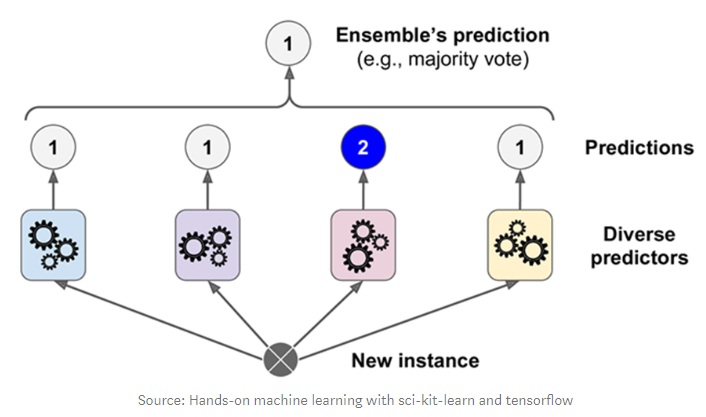  

2. **soft voting**
    - 다수의 추정기에서 각 레이블별 예측한 확률들의 평균을 내서 높은 레이블값을 결과값으로 선택하는 방식

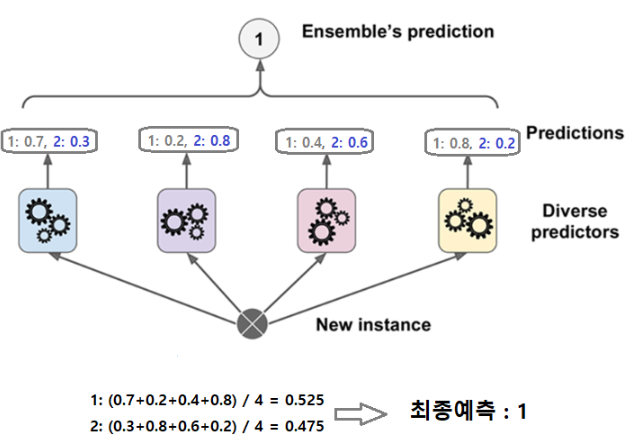

- 일반적으로 soft voting이 성능이 더 좋다.    
- 비슷한 성능을 내면서 서로 다른 예측하는 것이 많은 모델들을 묶어줄 때 성능이 올라간다.

## <span style='background-color:#fff5b1'>VotingClassifier 클래스 이용
- 매개변수
    - estimators : 앙상블할 모델들 설정.  ("추정기이름", 추정기) 의 튜플을 리스트로 묶어서 전달
    - voting: voting 방식. <span style='background-color:#fff5b1'>hard(기본값)</span>, soft  지정

## 위스콘신 유방암 데이터셋으로 실습

##### import

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

##### 데이터셋 로딩 및 train/test set 나누기

In [5]:
X, y = load_breast_cancer(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

##### Data전처리
- SVM, KNN, LogisticRegression은 Feature Scaling 전처리 데이터를 사용
- Random Forest, XGBoost는 Decision Tree기반이므로 Feature Scaling이 필요없다.

In [6]:
from sklearn.pipeline import Pipeline

In [29]:
# 각각 모델들의 최적의 하이퍼파라미터를 찾아 생성한 것이라 가정.
knn = Pipeline(steps = [('scaler',StandardScaler()),
                       ('knn', KNeighborsClassifier(n_neighbors=5))
                       ])
svc = Pipeline(steps = [('scaler',StandardScaler()),
                        ('svc', SVC(random_state = 0, probability = True))
                       ])
# svc는 soft voting 하려면 probability 를 True 로 설정해야한다.
rfc = RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0)
xgb = XGBClassifier(n_estimators = 500, learning_rate = 0.01, max_depth = 1, random_state = 0)

In [14]:
from metrics import print_metrics_classification as pmc

estimators = [
    ('KNN', knn),
    ('SVM', svc),
    ('Random Forest', rfc),
    ('XGBoost', xgb)    
]
# 각 모델이 test dataset에 대해서 추론한 결과를 저장.
test_pred_dict = {}
for name, model in estimators:
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    test_pred_dict[name] = test_pred
    pmc(y_train, train_pred, f'{name}의 train set')
    print('-'*40)
    pmc(y_test, test_pred, f'{name}의 test set')
    print('='*60)

KNN의 train set
정확도(accuracy): 0.9788732394366197
재현율/민감도(recall): 0.9850187265917603
정밀도(precision): 0.9813432835820896
F1-score: 0.9831775700934579
----------------------------------------
KNN의 test set
정확도(accuracy): 0.951048951048951
재현율/민감도(recall): 0.9888888888888889
정밀도(precision): 0.9368421052631579
F1-score: 0.9621621621621621
SVM의 train set
정확도(accuracy): 0.9929577464788732
재현율/민감도(recall): 0.9962546816479401
정밀도(precision): 0.9925373134328358
F1-score: 0.9943925233644859
----------------------------------------
SVM의 test set
정확도(accuracy): 0.958041958041958
재현율/민감도(recall): 0.9666666666666667
정밀도(precision): 0.9666666666666667
F1-score: 0.9666666666666667
Random Forest의 train set
정확도(accuracy): 0.9835680751173709
재현율/민감도(recall): 0.9962546816479401
정밀도(precision): 0.9779411764705882
F1-score: 0.987012987012987
----------------------------------------
Random Forest의 test set
정확도(accuracy): 0.9440559440559441
재현율/민감도(recall): 0.9555555555555556
정밀도(precision): 0.955555555555555

##### 모델들 생성, 학습, 평가

In [15]:
X_test.shape

(143, 30)

### 앙상블 상관관계
- 상관관계가 높은 모델을 앙상블에 포함시키는 것은 바람직 하지 않다.
- 모델간의 상관관계가 높다는 것은 두 모델이 동일한 예측을 한다는 것이다. 같은 예측을 하는 모델은 의미가 없다. 
- Voting방식(다수결 투표방식)의 앙상블은 각각 좋은 성능을 내지만 다른 예측을 하는 다양한 모델을 모아서 하는 것이 좋다.  대부분의 모델들이 동일한 예측을 만든다면 새로운 모델을 추가해 얻는 이득이 적다.

#### 모델간의 상관관계 확인
- 각 모델의 예측 결과를 이용해 상관계수를 구한다.

In [30]:
import pandas as pd

df = pd.DataFrame(test_pred_dict)
df.corr()
# 모델중 성능이 제일 좋은 것을 기준으로 상관계수 낮은 모델 순서로 묶어준다.

,KNN,SVM,Random Forest,XGBoost
KNN,1.000000,0.895618,0.926280,0.938373
SVM,0.895618,1.000000,0.880084,0.925128
Random Forest,0.926280,0.880084,1.000000,0.955492
XGBoost,0.938373,0.925128,0.955492,1.000000


**개별 성능이 가장 좋은 모델을 기준으로 상관계수가 낮은 모델을 선택해서 Voting 한다.**
- 성능: SVM
- voting: KNN, RandomForest

In [31]:
est = [
    ('svm', svc),
    ('knn', knn),
    ('rfc', rfc)
]

##### VotingClassifier로 앙상블
- estimators
    - 앙상블할 모델들을 묶어서 전달.  \[("모델이름", 모델객체), ...\]
- voting(voting 방식)
    - "hard" (기본-hard voting), "soft" - soft voting
    - 분류일때만 지정.   

###### hard voting

In [32]:
from sklearn.model_selection import cross_val_score
voting_hard = VotingClassifier(est)
result = cross_val_score(voting_hard,
                         X_train,
                         y_train,
                         cv = 4, scoring = 'accuracy', n_jobs = -1)

In [33]:
print(result)
print(result.mean())

[0.97196262 0.98130841 1.         0.98113208]
0.9836007758772702


In [35]:
# Test set 으로 최종 평가
voting_hard.fit(X_train, y_train)
test_pred = voting_hard.predict(X_test)
accuracy_score(y_test, test_pred)

0.951048951048951

###### soft voting

In [36]:
voting_soft = VotingClassifier(est, voting = 'soft')
result2 = cross_val_score(voting_soft, X_train, y_train, cv = 4, scoring = 'accuracy', n_jobs = -1)

In [37]:
print(result2)
print(result2.mean())

[0.98130841 0.98130841 0.99056604 0.99056604]
0.9859372244754011


In [38]:
# 최종평가
voting_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=0))])),
                             ('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier())])),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=200,
                                                     random_state=0))],
                 voting='soft')

In [39]:
accuracy_score(y_test, voting_soft.predict(X_test))

0.951048951048951